# Выполнил Лялин Илья Евгеньевич ББМО-02-24

# 1) Клонируем репозиторий

In [3]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# 2) Переходим в директорию DeepFool_Project

In [4]:
%cd EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


# 3) Импортируем необходимые библиотеки

In [5]:
# для работы с многомерными массивами и математическими операциями
import numpy as np

# для работы с JSON-данными (чтение/запись)
import json

# для работы с нейронными сетями
import torch

# для пакетной загрузки данных и random_split для разделения данных
from torch.utils.data import DataLoader, random_split

# Импорт готовых наборов данных (datasets) и архитектур моделей (models) из torchvision
from torchvision import datasets, models

# для предобработки изображений (аугментация, нормализация и т.д.)
from torchvision.transforms import transforms

In [6]:
# пользовательские модели нейронных сетей из локального модуля project_models
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net

# пользовательские утилиты из локального модуля project_utils
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

**FC_500_150** - полносвязная сеть (Fully Connected) с архитектурой 500 и 150 нейронами в скрытых слоях

**LeNet_CIFAR** - адаптация архитектуры LeNet для датасета CIFAR (32x32 цветные изображения), классическая CNN архитектура.

**LeNet_MNIST** - адаптация LeNet для датасета MNIST (28x28 черно-белые изображения цифр).

**Net** - обобщенная или базовая архитектура нейронной сети

**get_clip_bounds** - функция для получения границ отсечения (clipping bounds), для защиты от атак или ограничения значений.

**evaluate_attack** - функция для оценки эффективности атаки на модель, вычисления метрик успешности атаки.

**display_attack** - функция для визуализации результатов атаки, сравнения оригинальных и атакованных изображений.

# 4) Выбираем случайное значение по списку

In [7]:
rand_seed = 6
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# 5) Загружаем датасет MNIST

In [8]:
# Определение параметров нормализации для датасета MNIST
mnist_mean = 0.5  # среднее значение для нормализации
mnist_std = 0.5   # стандартное отклонение для нормализации
mnist_dim = 28    # размер изображений MNIST (28x28 пикселей)

# для вычисления граничных значений после нормализации
from utils.project_utils import get_clip_bounds

# Вычисление минимального и максимального значений после нормализации
# Это нужно для ограничения значений пикселей при adversarial атаках
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)

# Определение устройства для вычислений (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенос граничных значений на выбранное устройство (GPU/CPU)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

# Базовая трансформация для тестовых данных MNIST
mnist_tf = transforms.Compose([
    transforms.ToTensor(),  # конвертация PIL Image или numpy array в tensor
    transforms.Normalize(mean=mnist_mean, std=mnist_std)  # нормализация
])

# Расширенная трансформация для тренировочных данных с аугментацией
mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # случайное горизонтальное отражение (аугментация)
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

# Обратная трансформация для денормализации изображений
mnist_tf_inv = transforms.Compose([
    # Первый шаг: отмена масштабирования стандартного отклонения
    transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),
    # Второй шаг: отмена смещения среднего значения
    transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)
])

# Загрузка тренировочного датасета MNIST с применением аугментации
mnist_temp = datasets.MNIST(
    root='datasets/mnist',  # путь для сохранения датасета
    train=True,             # загрузка тренировочной части
    download=True,          # скачать если не существует
    transform=mnist_tf_train  # применить аугментацию
)

# Разделение датасета на тренировочную и валидационную части
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

# Загрузка тестового датасета MNIST с базовой трансформацией
mnist_test = datasets.MNIST(
    root='datasets/mnist',
    train=False,            # загрузка тестовой части
    download=True,
    transform=mnist_tf      # базовая трансформация без аугментации
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


Более простые трансформации - MNIST проще чем CIFAR-10

Меньший размер изображений - 28x28 vs 32x32

Один канал vs три канала у CIFAR-10

RandomHorizontalFlip() для цифр может быть проблематичным:

Цифры 6 и 9 становятся неразличимыми после отражения

Другие цифры также могут меняться семантически

Лучше использовать: повороты, небольшие сдвиги, шум

Аугментация данных (Data Augmentation) - это техника искусственного увеличения размера тренировочного набора данных путем применения различных преобразований к исходным данным.


Аугментация помогает сделать модель более устойчивой к небольшим искажениям, что может повысить сопротивляемость к adversarial атакам, так как модель учится игнорировать небольшие изменения во входных данных.

# 6) Загружаем датасет CIFAR-10

In [9]:
# Определение параметров нормализации для CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]  # средние значения для каждого из 3 каналов (RGB)
cifar_std = [0.202, 0.199, 0.201]   # стандартные отклонения для каждого канала
cifar_dim = 32                       # размер изображений CIFAR-10 (32x32 пикселя)

# для вычисления граничных значений
from utils.project_utils import get_clip_bounds

# Вычисление минимального и максимального значений после нормализации
# Для CIFAR-10 учитывается 3 канала (цветное изображение)
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)

# Определение устройства для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенос граничных значений на выбранное устройство
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

# Базовая трансформация для тестовых данных CIFAR-10
cifar_tf = transforms.Compose([
    transforms.ToTensor(),  # конвертация в tensor и нормализация к [0,1]
    transforms.Normalize(mean=cifar_mean, std=cifar_std)  # нормализация по каналам
])

# Расширенная трансформация для тренировочных данных с аугментацией
cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),  # случайная обрезка с padding
    transforms.RandomHorizontalFlip(),                 # случайное горизонтальное отражение
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

# Обратная трансформация для денормализации изображений CIFAR-10
cifar_tf_inv = transforms.Compose([
    # Отмена нормализации стандартного отклонения для каждого канала
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
    # Отмена нормализации среднего значения для каждого канала
    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])
])

# Загрузка тренировочного датасета CIFAR-10 с аугментацией
cifar_temp = datasets.CIFAR10(
    root='datasets/cifar-10',  # путь для сохранения
    train=True,                # тренировочная часть
    download=True,             # скачать если нет
    transform=cifar_tf_train   # трансформация с аугментацией
)

# Разделение на тренировочную (40,000) и валидационную (10,000) части
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

# Загрузка тестового датасета CIFAR-10
cifar_test = datasets.CIFAR10(
    root='datasets/cifar-10',
    train=False,               # тестовая часть
    download=True,
    transform=cifar_tf         # базовая трансформация
)

# Определение названий классов CIFAR-10
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Сложнее MNIST - цветные изображения реальных объектов

Больше вариативности - разные углы, освещение, фон

Требует более сложных моделей для хорошей точности

# 7) Выполним настройку и загрузку DataLoader

In [10]:
# Установка параметров для DataLoader
batch_size = 64    # размер мини-батча (количество образцов за одну итерацию)
workers = 4        # количество процессов для загрузки данных

# Создание DataLoader для MNIST датасета
mnist_loader_train = DataLoader(
    mnist_train,           # тренировочные данные
    batch_size=batch_size, # размер батча
    shuffle=True,          # перемешивание данных перед каждой эпохой
    num_workers=workers    # количество процессов для загрузки
)

mnist_loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    shuffle=False,         # для валидации перемешивание не нужно
    num_workers=workers
)

mnist_loader_test = DataLoader(
    mnist_test,
    batch_size=batch_size,
    shuffle=False,         # для тестирования перемешивание не нужно
    num_workers=workers
)

# Создание DataLoader для CIFAR-10 датасета
cifar_loader_train = DataLoader(
    cifar_train,
    batch_size=batch_size,
    shuffle=True,          # перемешивание для тренировки
    num_workers=workers
)

cifar_loader_val = DataLoader(
    cifar_val,
    batch_size=batch_size,
    shuffle=False,         # без перемешивания для валидации
    num_workers=workers
)

cifar_loader_test = DataLoader(
    cifar_test,
    batch_size=batch_size,
    shuffle=False,         # без перемешивания для тестирования
    num_workers=workers
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Разница между загрузчиками:**
Тренировочные загрузчики:
shuffle=True - каждый эпоха видит данные в разном порядке

Используются для обновления весов модели

Валидационные загрузчики:
shuffle=False - стабильная оценка на фиксированном наборе

Используются для подбора гиперпараметров

Тестовые загрузчики:
shuffle=False - окончательная оценка производительности

Данные используются только для инференса

# 8) Загрузка и оценка стойкости модели NIN к FGSM и DeepFool атакам

In [11]:
# Загрузка и оценка стойкости модели Network-In-Network Model к FGSM и DeepFool атакам

# Установка параметра epsilon для FGSM атаки
fgsm_eps = 0.2

# Создание экземпляра модели Net() и перенос на выбранное устройство (GPU/CPU)
model = Net().to(device)

# Загрузка предобученных весов для модели
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=device))

# Оценка устойчивости к FGSM атаке
evaluate_attack(
    'cifar_nin_fgsm.csv',     # имя файла для сохранения результатов
    'results',                # директория для сохранения
    device,                   # устройство для вычислений
    model,                    # тестируемая модель
    cifar_loader_test,        # тестовый датасет
    cifar_min,                # минимальные значения пикселей (для clipping)
    cifar_max,                # максимальные значения пикселей
    fgsm_eps,                 # параметр epsilon для FGSM
    is_fgsm=True              # флаг указания типа атаки (FGSM)
)
print('')

# Параметры для DeepFool атаки
deep_args = [64, 10, 0.02, 100]  # максимум итераций

# Оценка устойчивости к DeepFool атаке
evaluate_attack(
    'cifar_nin_deepfool.csv', # имя файла для сохранения результатов
    'results',                # директория для сохранения
    device,                   # устройство для вычислений
    model,                    # тестируемая модель
    cifar_loader_test,        # тестовый датасет
    cifar_min,                # минимальные значения пикселей
    cifar_max,                # максимальные значения пикселей
    deep_args,                # параметры для DeepFool
    is_fgsm=False             # флаг указания типа атаки (не FGSM = DeepFool)
)

# Очистка памяти GPU если используется CUDA
if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


**FGSM (Fast Gradient Sign Method):**
Быстрая white-box атака

Использует градиент функции потерь

Параметр fgsm_eps = 0.2 - контролирует величину возмущения

Простая но эффективная атака

**DeepFool:**
Более сложная итеративная атака

Находит минимальное возмущение для изменения класса


**Процесс оценки:**
Загрузка чистой модели - модель, обученная на чистых данных

Генерация adversarial примеров с помощью выбранной атаки

Оценка точности модели на атакованных данных

Сравнение с исходной точностью - измерение степени деградации

Сохранение результатов в CSV файлы для последующего анализа

**Параметры clipping:**
cifar_min, cifar_max - ограничивают значения пикселей чтобы они оставались валидными

Предотвращают создание нереалистичных изображений

# 9) Загрузка и оценка стойкости LeNet к FGSM и DeepFool атакам

In [12]:
# Установка параметра epsilon для FGSM атаки
fgsm_eps = 0.1  # меньшая величина возмущения, возможно из-за большей уязвимости LeNet

# Создание экземпляра модели LeNet, специализированной для CIFAR-10
model = LeNet_CIFAR().to(device)

# Загрузка предобученных весов для модели LeNet
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=device))

# Оценка устойчивости к FGSM атаке
evaluate_attack(
    'cifar_lenet_fgsm.csv',   # имя файла для сохранения результатов LeNet
    'results',                # директория для сохранения
    device,                   # устройство для вычислений
    model,                    # тестируемая модель LeNet
    cifar_loader_test,        # тестовый датасет CIFAR-10
    cifar_min,                # минимальные значения пикселей
    cifar_max,                # максимальные значения пикселей
    fgsm_eps,                 # параметр epsilon для FGSM (0.1 vs 0.2 для NiN)
    is_fgsm=True              # флаг указания типа атаки (FGSM)
)
print('')

# Параметры для DeepFool атаки
deep_args = [64, 10, 0.02, 100]  # максимум итераций

# Оценка устойчивости к DeepFool атаке
evaluate_attack(
    'cifar_lenet_deepfool.csv', # имя файла для сохранения результатов
    'results',                  # директория для сохранения
    device,                     # устройство для вычислений
    model,                      # тестируемая модель LeNet
    cifar_loader_test,          # тестовый датасет
    cifar_min,                  # минимальные значения пикселей
    cifar_max,                  # максимальные значения пикселей
    deep_args,                  # параметры для DeepFool
    is_fgsm=False               # флаг указания типа атаки (DeepFool)
)

# Очистка памяти GPU если используется CUDA
if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


**Архитектура LeNet**

LeNet - классическая CNN архитектура (1998 год)

Более простая по сравнению с NiN

Меньшая емкость - возможно более уязвима к атакам



Более уязвима чем NiN из-за простоты архитектуры

Меньшая способность к обучению сложным признакам

Быстрее достигает насыщения по точности

**Параметр FGSM атаки:**

Требуется меньше искажений для успешной атаки

# 10) LeNet на датасете MNIST

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


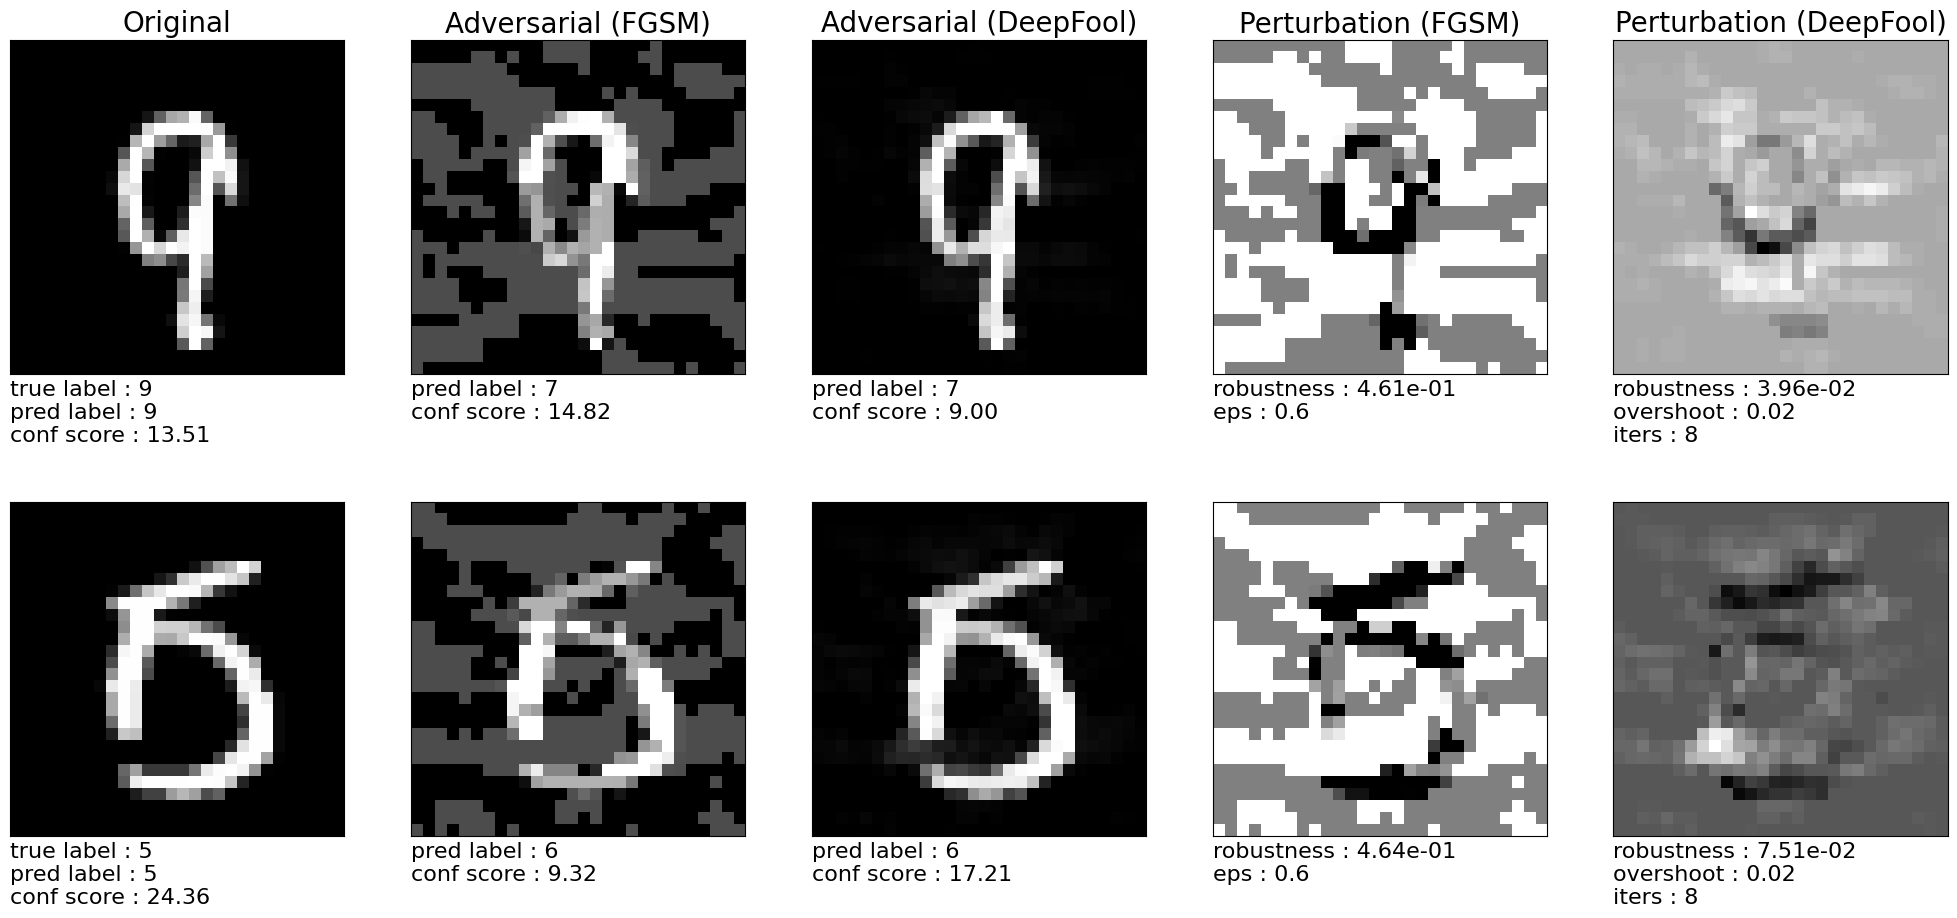

In [13]:
fgsm_eps = 0.6

# Создание экземпляра модели LeNet, специализированной для MNIST
model = LeNet_MNIST().to(device)

# Загрузка предобученных весов для модели LeNet на MNIST
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

# Визуализация adversarial атак на MNIST датасете
display_attack(
    device,           # устройство для вычислений (GPU/CPU)
    model,            # тестируемая модель LeNet для MNIST
    mnist_test,       # тестовый датасет MNIST
    mnist_tf_inv,     # обратная трансформация для денормализации изображений
    mnist_min,        # минимальные значения пикселей после нормализации
    mnist_max,        # максимальные значения пикселей после нормализации
    fgsm_eps,         # параметр epsilon для FGSM атаки
    deep_args,        # параметры для DeepFool атаки
    has_labels=False, # флаг: не отображать истинные метки (или отображать предсказания)
    l2_norm=True,     # отображать L2 норму возмущений
    pert_scale=1.0,   # масштаб визуализации возмущений
    fig_rows=2,       # количество строк в визуализации
    fig_width=25,     # ширина фигуры для отображения
    fig_height=11     # высота фигуры для отображения
)

if device.type == 'cuda':
    torch.cuda.empty_cache()

# 11) FCNet на датасете MNIST

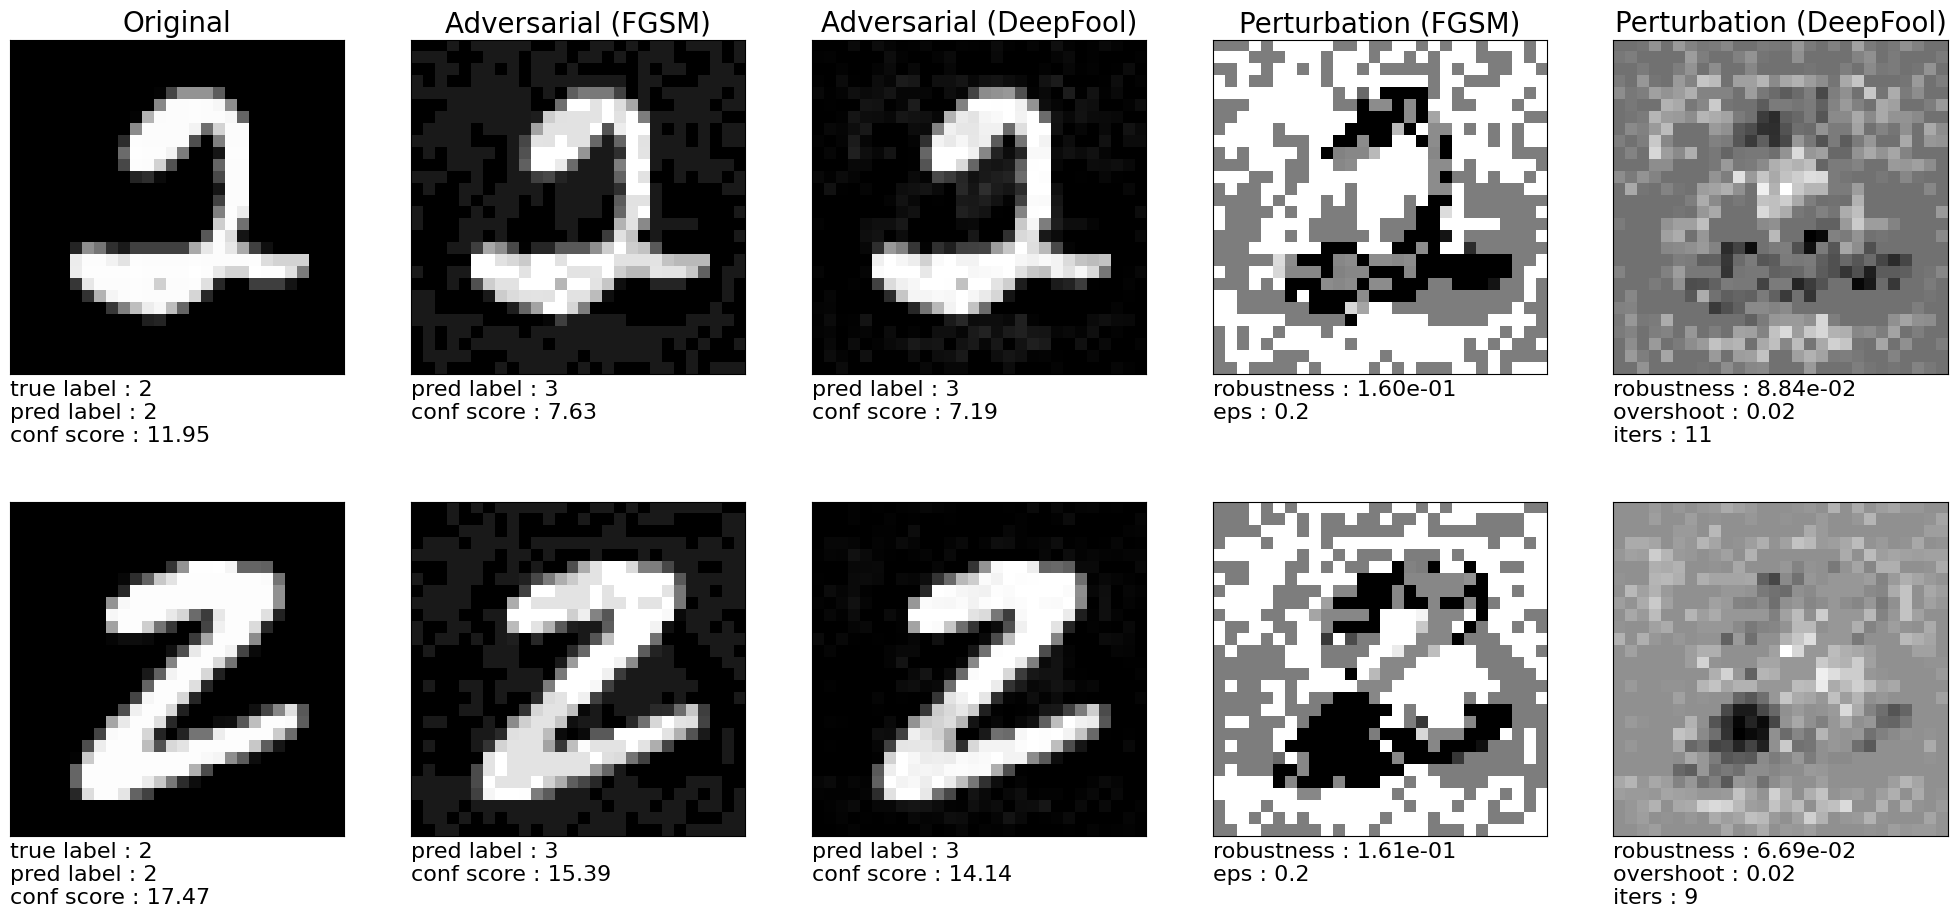

In [14]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

# 12) NIN (Network-in-Network) на датасете CIFAR-10

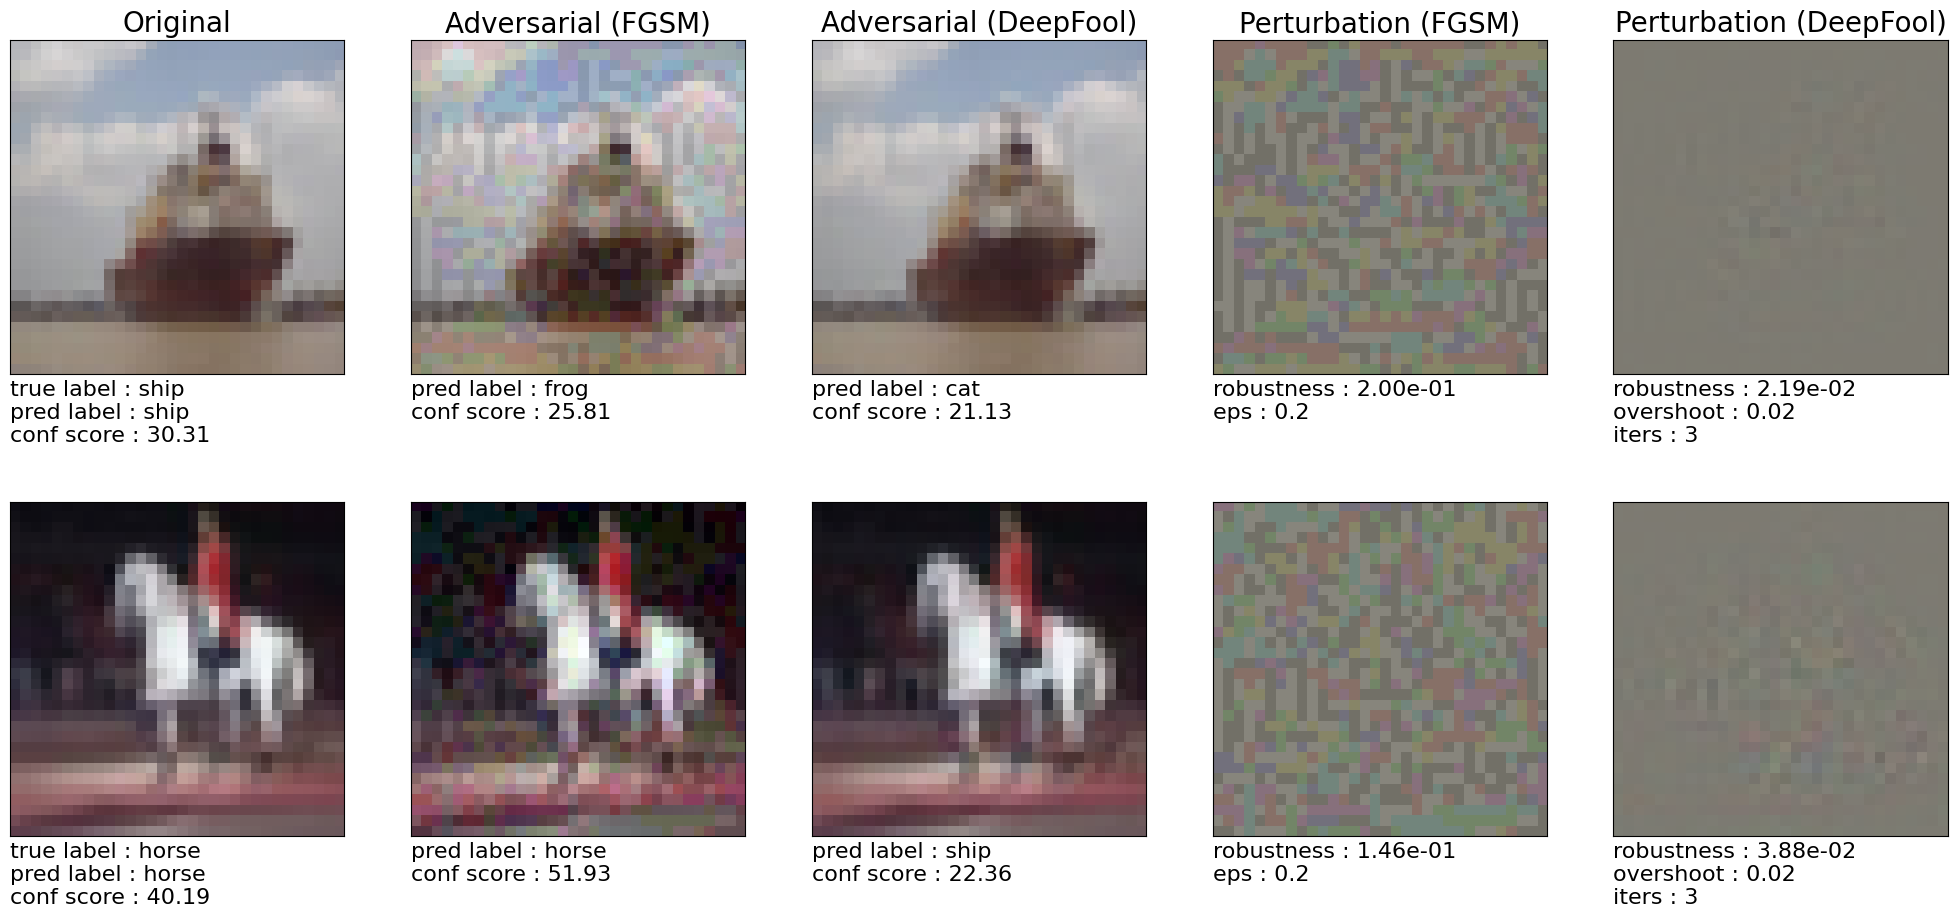

In [15]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

# 13) LeNet на датасете CIFAR-10

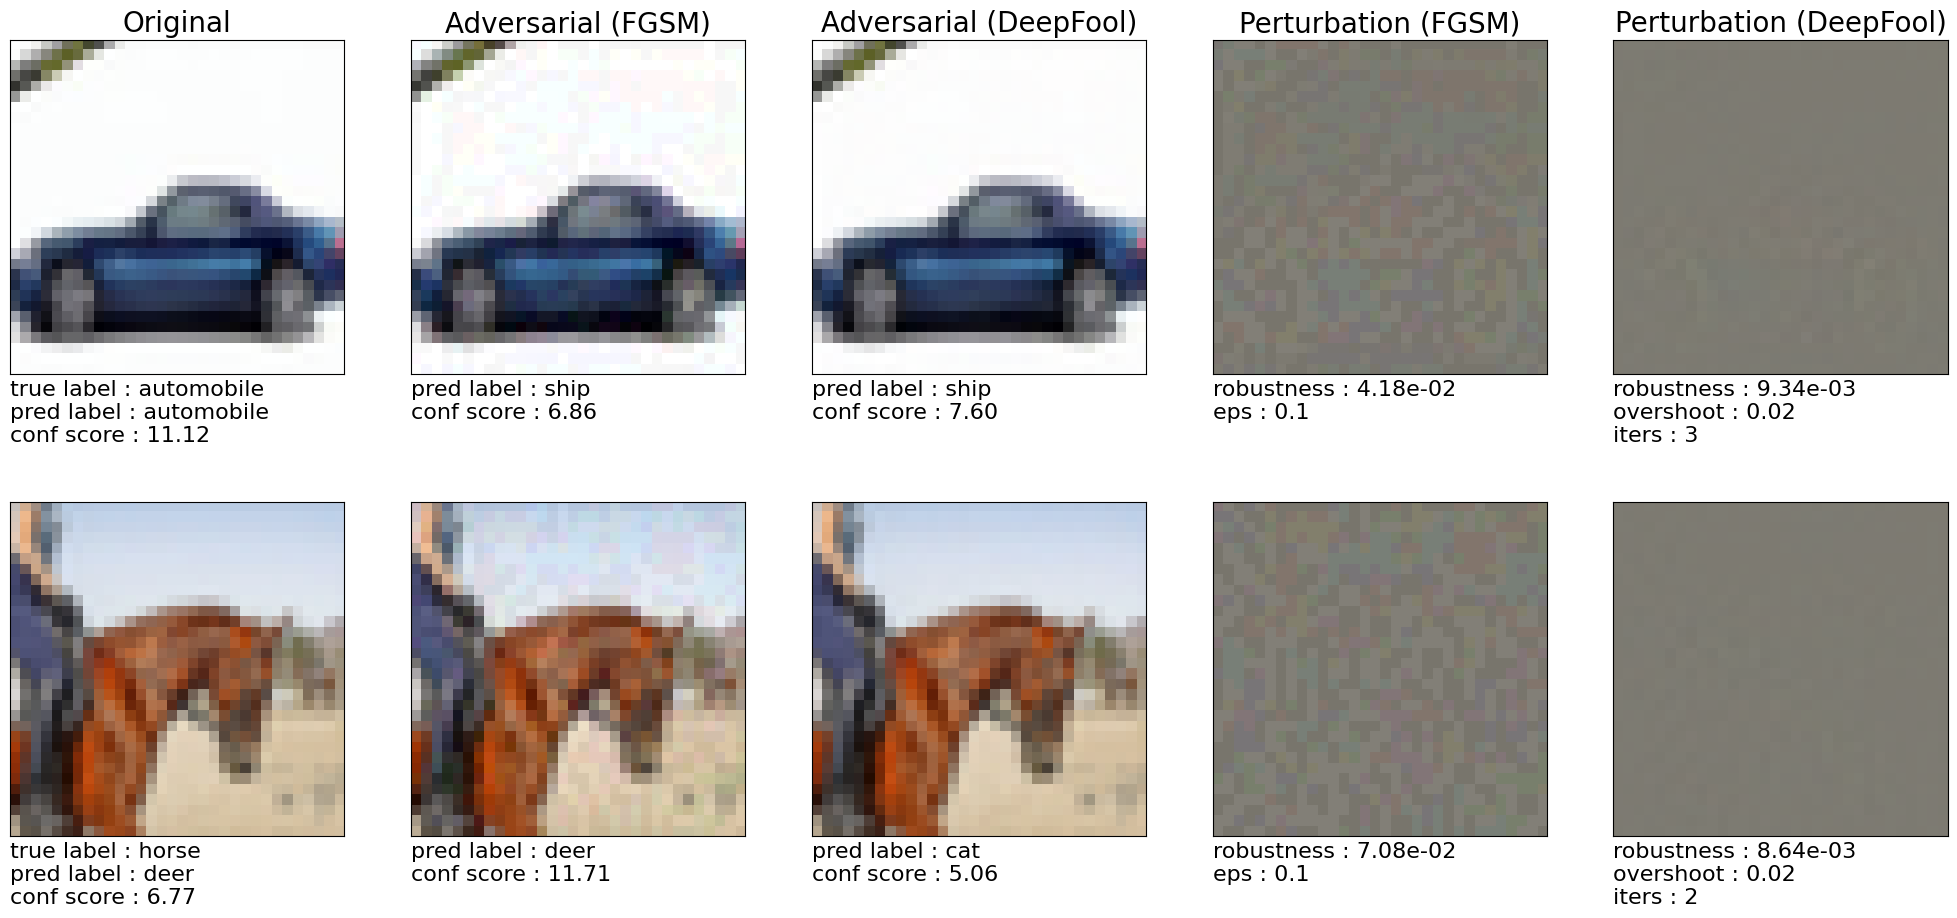

In [16]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)


if device.type == 'cuda': torch.cuda.empty_cache()

# 14) Отражение отличий для значения эпсилон: 0.001, 0.02, 0.5, 0.9, 10 для сетей FC LeNet на датасете MNIST, NIN LeNet на датасете CIFAR

In [17]:
# Определение различных значений epsilon для FGSM атаки
EPSILONS = [0.001, 0.02, 0.5, 0.9, 10]  # широкий диапазон возмущений

# Список моделей и их параметров для тестирования
MODELS = [
    # Первая модель: полносвязная сеть для MNIST
    ('FC_500_150 (MNIST)',           # название модели для вывода
     FC_500_150,                     # класс модели
     'weights/clean/mnist_fc.pth',   # путь к весам
     mnist_loader_test,              # тестовый загрузчик данных
     mnist_min,                      # минимальные значения пикселей
     mnist_max,                      # максимальные значения пикселей
     'mnist_fc_fgsm_eps{eps}.csv'), # шаблон имени файла для результатов

    # Вторая модель: NiN сеть для CIFAR-10
    ('NiN_LeNet (CIFAR-10)',         # название модели
     Net,                            # класс модели (NiN)
     'weights/clean/cifar_nin.pth',  # путь к весам
     cifar_loader_test,              # тестовый загрузчик данных
     cifar_min,                      # минимальные значения пикселей
     cifar_max,                      # максимальные значения пикселей
     'cifar_nin_fgsm_eps{eps}.csv') # шаблон имени файла
]

# Основной цикл по всем значениям epsilon
for i, eps in enumerate(EPSILONS, 1):  # перечисление начиная с 1
    print ("="*50)
    print(f"\n [{i}/{len(EPSILONS)}] ε = {eps:.3f}")  # номер итерации и текущий epsilon

    # Вложенный цикл по всем моделям для текущего epsilon
    for name, model_class, weights, loader, min_val, max_val, file_template in MODELS:
        print(f"    {name}")

        # Создание и загрузка модели
        model = model_class().to(device)  # инициализация модели на устройстве
        model.load_state_dict(torch.load(weights))  # загрузка предобученных весов
        model.eval()  # перевод модели в режим оценки

        # Оценка устойчивости к FGSM атаке с текущим epsilon
        evaluate_attack(
            file_template.format(eps=eps),  # имя файла с подставленным epsilon
            'results',                      # директория для сохранения
            device,                         # устройство вычислений
            model,                          # тестируемая модель
            loader,                         # загрузчик тестовых данных
            min_val,                        # минимальные значения пикселей
            max_val,                        # максимальные значения пикселей
            eps,                            # текущее значение epsilon
            True                            # флаг FGSM атаки
        )

        # Вывод информации о сохраненном файле
        print(f"    {file_template.format(eps=eps)}")
        print("\n")

        # Очистка памяти GPU после каждой модели
        if device.type == 'cuda':
            torch.cuda.empty_cache()


 [1/5] ε = 0.001
    FC_500_150 (MNIST)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.84 s
FGSM Time (Per Image) : 83.71 us
    mnist_fc_fgsm_eps0.001.csv


    NiN_LeNet (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.11%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.78 s
FGSM Time (Per Image) : 178.31 us
    cifar_nin_fgsm_eps0.001.csv



 [2/5] ε = 0.020
    FC_500_150 (MNIST)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.88 s
FGSM Time (Per Image) : 87.61 us
    mnist_fc_fgsm_eps0.02.csv


    NiN_LeNet (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.77%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.23 s
FGSM Time (Per Image) : 122.57 us
    cifar_nin_fgsm_eps0.02.csv



 [3/5] ε = 0.500
    FC_500_150 (MNIST)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.80 s
FGSM Time (Per Image) : 80.33 us
    mnist_fc_fgsm_eps0.5.csv


    NiN_LeNet (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.61%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.01 s
FGSM Time (Per Image) : 101.09 us
    cifar_nin_fgsm_eps0.5.csv



 [4/5] ε = 0.900
    FC_500_150 (MNIST)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.79 s
FGSM Time (Per Image) : 78.90 us
    mnist_fc_fgsm_eps0.9.csv


    NiN_LeNet (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.62%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.25 s
FGSM Time (Per Image) : 125.10 us
    cifar_nin_fgsm_eps0.9.csv



 [5/5] ε = 10.000
    FC_500_150 (MNIST)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.77 s
FGSM Time (Per Image) : 76.74 us
    mnist_fc_fgsm_eps10.csv


    NiN_LeNet (CIFAR-10)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.49%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.29 s
FGSM Time (Per Image) : 128.74 us
    cifar_nin_fgsm_eps10.csv




# NiN значительно устойчивее FC к FGSM атакам